# Convert pdf to img

In [10]:
import pymupdf
from tqdm import tqdm

# Get all pdf files in the current directory
from pathlib import Path
pdf_files = list(Path().rglob("*.pdf"))

# Convert all pdf files to images
for pdf_file in tqdm(pdf_files):
    pdf = pymupdf.open(pdf_file)
    # Create a directory
    Path(pdf_file.stem).mkdir(exist_ok=True)

    for page in pdf:
        image = page.get_pixmap()
        image.save(f"{pdf_file.stem}/{pdf_file.stem}_{page.number}.png", "png")
    pdf.close()





100%|██████████| 6/6 [00:35<00:00,  5.84s/it]


# Open CV tests

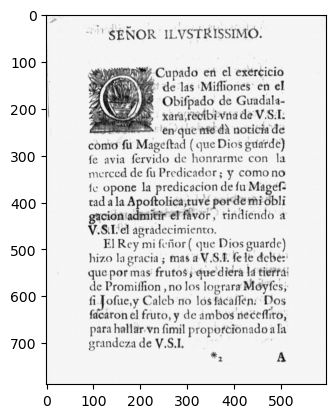

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm

image_dir = Path("Ezcaray - Vozes")

# Load the image
image = cv2.imread(str(image_dir / "Ezcaray - Vozes_0.png"))

# Show the image
plt.imshow(image)


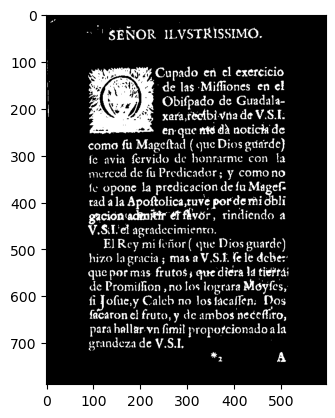

In [39]:
# Binary thresholding
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Show the binary image
plt.imshow(binary, cmap="gray")

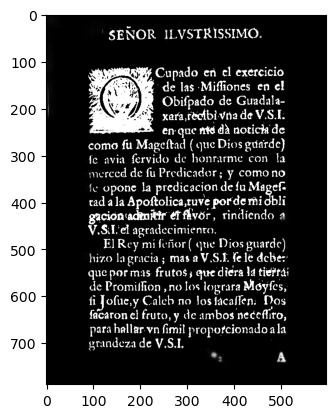

In [42]:
# Preprocessing
# Denoising
denoised = cv2.fastNlMeansDenoising(binary, None, 30, 50, 30)

# Show the denoised image
plt.imshow(denoised, cmap="gray")

0.9548412561416626
90.0


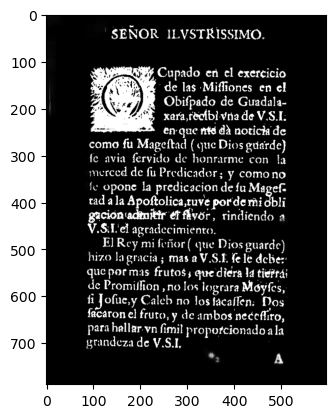

In [ ]:
# Text alignment

def align_text(img):
  coords = np.column_stack(np.where(img > 0))
  angle = cv2.minAreaRect(coords)[-1]
  print(angle)
  if angle == 0 or angle == -0.0 or angle == 90.0 or angle == -90.0: 
    return img
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  h,w = img.shape
  center = (w // 2, h // 2)
  
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(img, M, (w, h),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated

# align image text
img = align_text(denoised)
plt.imshow(img, cmap="gray")

plt.show()

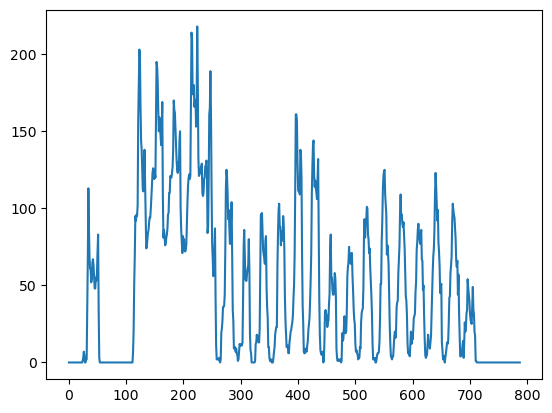

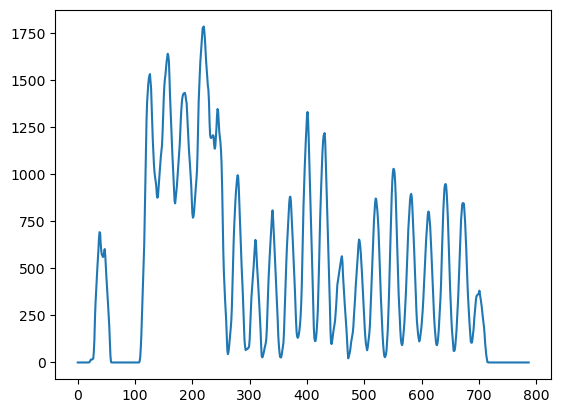

[(29, 56), (111, 260), (266, 291), (300, 319), (329, 350), (360, 382), (387, 413), (417, 441), (446, 469), (480, 501), (509, 532), (541, 563), (569, 594), (599, 624), (630, 654), (661, 685), (690, 710)]


In [ ]:
# split text into rows
# find sum of column values, row-wise
a = np.sum(img == 255, axis=1)
# Plot HPP 
plt.plot(a)
plt.show()

# Smooth the HPP
a = np.convolve(a, np.ones(10), mode='same')
plt.plot(a)
plt.show()

# find the threshold value
threshold = 0.1 * np.max(a)
# find the rows where the sum of column values is lesser than the threshold
rows = np.where(a < threshold)[0]

#print(rows)

# combine consecutive rows
consecutive_rows = []
prev = rows[1]

#print(rows)

row_pixel_threshold = 2

for row in rows:
    if row - prev > row_pixel_threshold:
        consecutive_rows.append((prev, row))

    prev = row

print(consecutive_rows)
        


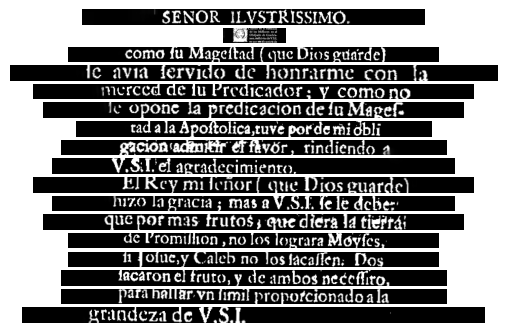

In [64]:
# Show the first n rows
n_rows = 20
for i, (start, end) in enumerate(consecutive_rows[:n_rows]):
    plt.subplot(n_rows, 1, i + 1)
    plt.imshow(img[start:end], cmap="gray")
    plt.axis("off")
  

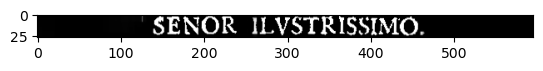

[(135, 239), (265, 463)]


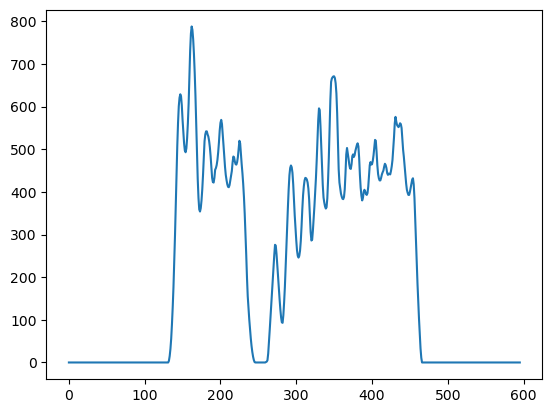

In [83]:
# Find vpp and split the text into words

row_img = img[consecutive_rows[0][0]:consecutive_rows[0][1]]
vpp = np.sum(row_img == 255, axis=0)
vpp = np.convolve(vpp, np.ones(10), mode='same')
vpp = np.convolve(vpp, np.ones(10), mode='same')

plt.imshow(row_img, cmap="gray")
plt.show()

plt.plot(vpp)

# find the threshold value
threshold = 0.1 * np.max(vpp)
# find the rows where the sum of column values is lesser than the threshold
columns = np.where(vpp < threshold)[0]


# combine consecutive cols
consecutive_columns = []

prev = columns[1]
column_pixel_threshold = 2

for column in columns:
    if column - prev > column_pixel_threshold:
        consecutive_columns.append((prev, column))

    prev = column

print(consecutive_columns)


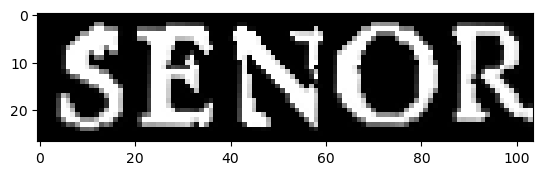

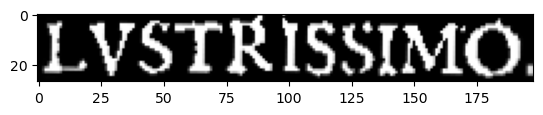

In [84]:
# Show all the words

for col in consecutive_columns:
    plt.imshow(row_img[:, col[0]:col[1]], cmap="gray")
    plt.show()

# Data for Ornamental letters

In [ ]:
# Download images from batyr 
url_template = "http://www.bvh.univ-tours.fr/batyr/beta/notice_bois.php?IdBois="

import requests

for i in tqdm(range(15133, 30000)):
    url = url_template + str(i)
    response = requests.get(url)
    if response.status_code == 200:
        # Get the jpg in the html
        jpg_url = response.text.find("_lettrine_")
        if (jpg_url == -1):
            continue
        jpg_url = response.text[jpg_url - 100:jpg_url + 20]
        #print(jpg_url)
        jpg_url = jpg_url.split("../")[1]
        jpg_url = jpg_url.split(".jpg")[0]
        jpg_url = jpg_url + ".jpg"


        jpg_url = "http://www.bvh.univ-tours.fr/batyr/" + jpg_url
        #print(i,jpg_url)

        letter_text = response.text.find("Lettre :")
        letter = "unk"
        if (letter_text != -1):
            letter_text = response.text[letter_text:letter_text + 30]
            #print("Letter_text:", letter_text)
            #print(i)
            letter = letter_text.split("</br>")[0] 
            #print("Letter:", letter)
            letter = letter.split(">")[1]
            
        #print("Letter:", letter)



        # Download the jpg
        jpg_response = requests.get(jpg_url)
        Path("images").mkdir(exist_ok=True)
        with open(f"images/{i}_{letter}.jpg", "wb") as f:
            f.write(jpg_response.content)

    else:
        continue

  5%|▍         | 756/15617 [11:41<3:49:51,  1.08it/s] 


KeyboardInterrupt: 

J
K
U
W


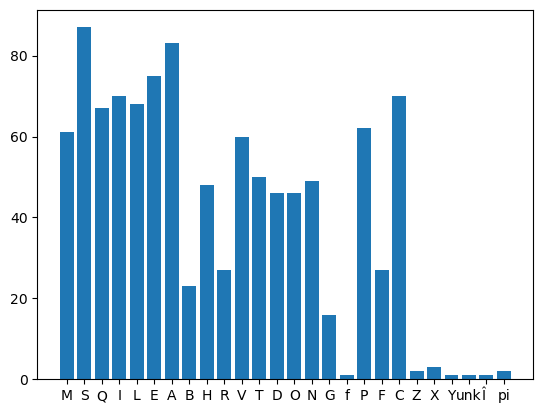

In [121]:
# Check the distribution
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter


images = list(Path("images").rglob("*.jpg"))
letters = [image.name.split("_")[1].split(".")[0] for image in images]

letter_counter = Counter(letters)

# Which alphabet is missing
for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    if letter not in letter_counter:
        print(letter)

plt.bar(letter_counter.keys(), letter_counter.values())
plt.show()

# Ornamental letter recognition

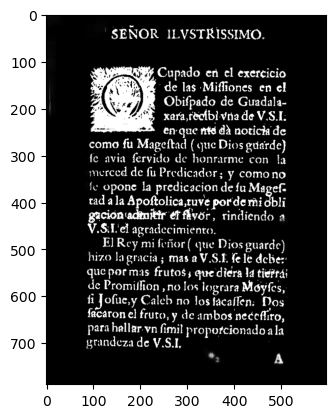

In [125]:
plt.imshow(img,cmap="gray")
plt.show()

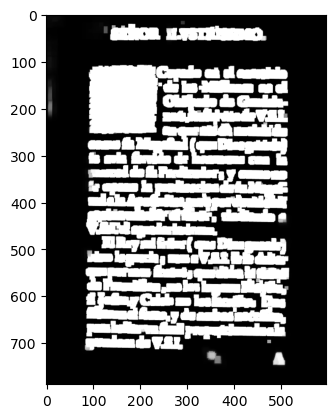

In [139]:
# Dilate the image
kernel = np.ones((7,8), np.uint8)
dilated = cv2.dilate(img, kernel, iterations=1)
plt.imshow(dilated, cmap="gray")
plt.show()

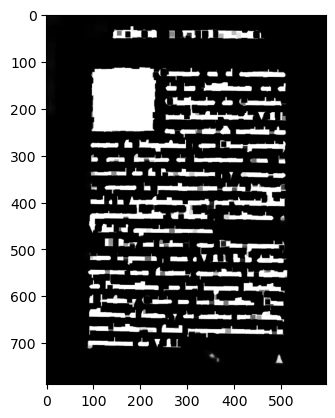

In [140]:
# Erode the image
kernel = np.ones((10,10), np.uint8)
eroded = cv2.erode(dilated, kernel, iterations=1)
plt.imshow(eroded, cmap="gray")
plt.show()

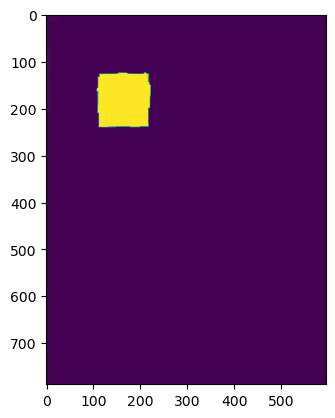

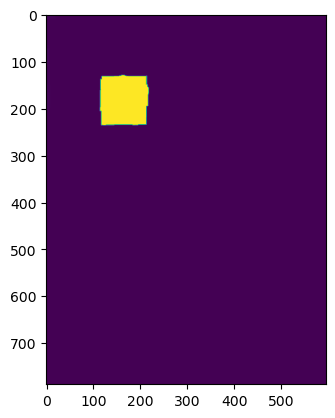

In [147]:

# erode the image to remove the noise further
kernel = np.ones((20,20), np.uint8)
eroded_2 = cv2.erode(eroded, kernel, iterations=1)

plt.imshow(eroded_2)
plt.show()

# Erode further to remove the noise
kernel = np.ones((10,10), np.uint8)
eroded_3 = cv2.erode(eroded_2, kernel, iterations=1)

plt.imshow(eroded_3)
plt.show()


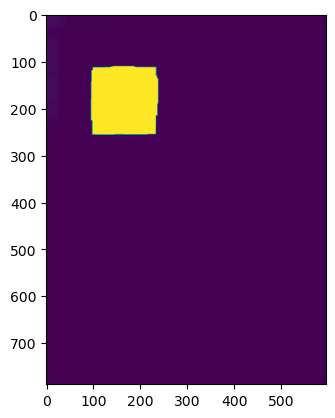

In [150]:
# Dilate the image to create a mask for the drop cap
kernel = np.ones((40,40), np.uint8)
dilated = cv2.dilate(eroded_3, kernel, iterations=1)

plt.imshow(dilated)
plt.show()


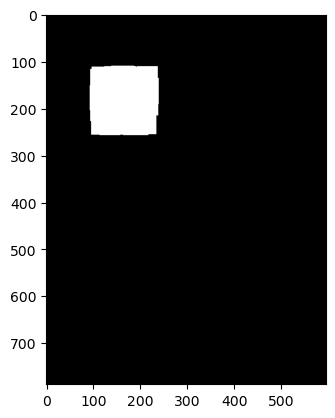

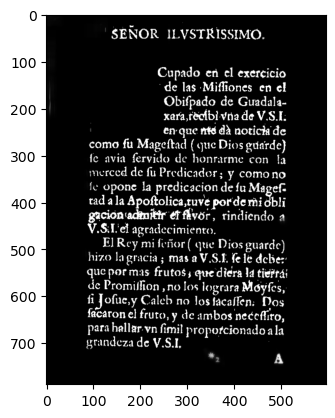

In [153]:
# Find the contours
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask
mask = np.zeros_like(dilated)

# Draw the largest contour on the mask
cv2.drawContours(mask, [largest_contour], -1, 255, -1)

# Show the mask
plt.imshow(mask, cmap="gray")
plt.show()

# Apply the mask to the original image to remove the drop cap
masked = cv2.bitwise_and(img, img, mask=~mask)

# Show the masked image
plt.imshow(masked, cmap="gray")
plt.show()